In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 57.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=3d6df952be0f5e4f1b14df36130984e5b0b1074985d55fd7ad1ffa172c150065
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:

from google.colab import files

uploads = files.upload()

Saving diabetes.csv to diabetes.csv


In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sc = SparkSession.builder.appName('Diabetes').getOrCreate()

In [5]:
df = sc.read.csv('/content/diabetes.csv', header= True, inferSchema=True)
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [6]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [7]:
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [8]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



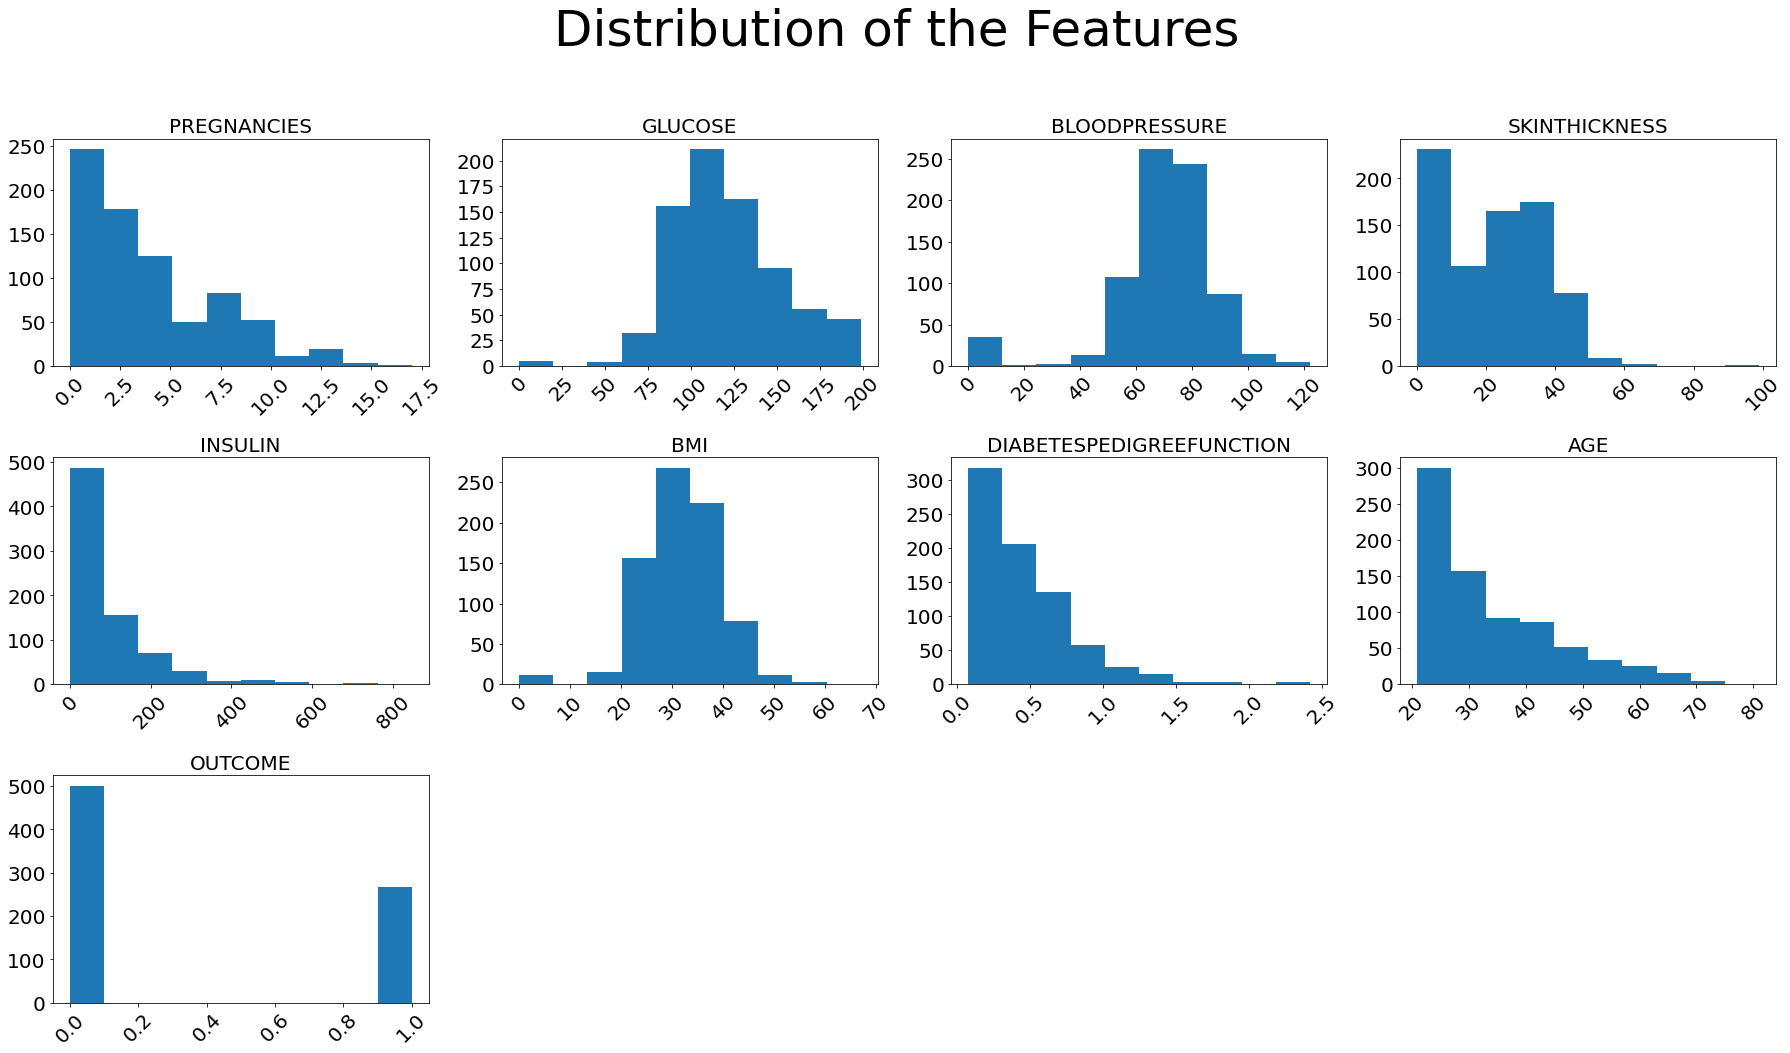

In [9]:
fig = plt.figure(figsize=(25,15))
st = fig.suptitle("Distribution of the Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
    ax=fig.add_subplot(3,4, num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.40)
plt.show()

In [10]:
from pyspark.sql.functions import isnan, when, count, col

In [11]:
# checking missing value
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head() 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


In [12]:
# user define functions

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [13]:
# converting the outcome col into yes or no for the person if they have diabetes or not!
y_udf = udf(lambda y: "no" if y == 0 else "yes", StringType())

In [14]:
df = df.withColumn("HasDiabetes", y_udf('Outcome')).drop('Outcome')
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 5 rows



In [15]:
# age grouping

def udf_multi(age):
    if(age <= 25):
        return "Under 25"
    elif (age >=25 and age <= 35):
        return "Between 25 and 35"
    elif (age > 35 and age < 50):
        return "Betweenm 36 and 50"
    elif (age >= 50):
        return " Over 50"
    else:
        return "NA"

In [16]:
age_udf = udf(udf_multi)
df = df.withColumn('age_udf', age_udf('Age'))
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|         Under 25|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|Between 25 and 35|
+-----------+-------+---

In [17]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank, sum, col, desc
from pyspark.sql import Window

In [18]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [20]:
age_group_tab = df.select(['age_udf', "Glucose"]).\
                groupBy('age_udf').\
                    agg(
                        F.count('Glucose').alias('UserCount'),
                        F.mean('Glucose').alias('Glucose_AVG'),
                        F.min('Glucose').alias('Glucose_MIN'),
                        F.max('Glucose').alias('Glucose_MAX')).\
                    withColumn('total', sum(col('UserCount')).over(window)).\
                    withColumn('Percent', col('UserCount')*100 / col('total')).\
                    drop(col('total')).sort(desc('Percent'))
                    

In [21]:
age_group_tab.toPandas()

,age_udf,UserCount,Glucose_AVG,Glucose_MIN,Glucose_MAX,Percent
0,Under 25,267,110.719101,0,199,34.765625
1,Between 25 and 35,231,121.670996,71,198,30.078125
2,Betweenm 36 and 50,181,125.740331,0,197,23.567708
3,Over 50,89,139.550562,57,197,11.588542


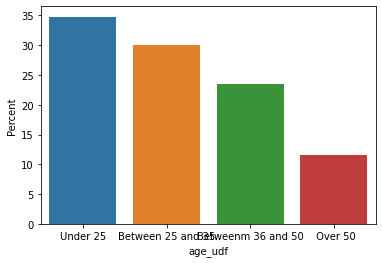

In [24]:
sns.barplot(x='age_udf', y='Percent', data=age_group_tab.toPandas());

In [26]:
# coorelations
df.printSchema()


root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- HasDiabetes: string (nullable = true)
 |-- age_udf: string (nullable = true)



In [29]:
# extracting all the numeric feature usign a simple function
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_feature_df = df.select(numeric_features)
numeric_feature_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [31]:
col_names = numeric_feature_df.columns
features = numeric_feature_df.rdd.map(lambda row: row[0:])

In [32]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [33]:
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.0000,0.1295,0.1413,-0.0817,-0.0735,0.0177,-0.0335,0.5443
Glucose,0.1295,1.0000,0.1526,0.0573,0.3314,0.2211,0.1373,0.2635
BloodPressure,0.1413,0.1526,1.0000,0.2074,0.0889,0.2818,0.0413,0.2395
SkinThickness,-0.0817,0.0573,0.2074,1.0000,0.4368,0.3926,0.1839,-0.1140
Insulin,-0.0735,0.3314,0.0889,0.4368,1.0000,0.1979,0.1851,-0.0422
BMI,0.0177,0.2211,0.2818,0.3926,0.1979,1.0000,0.1406,0.0362
DiabetesPedigreeFunction,-0.0335,0.1373,0.0413,0.1839,0.1851,0.1406,1.0000,0.0336
Age,0.5443,0.2635,0.2395,-0.1140,-0.0422,0.0362,0.0336,1.0000


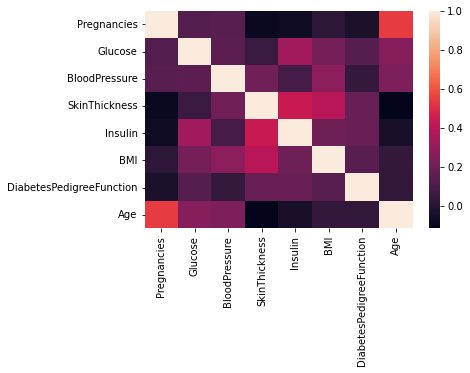

In [34]:
sns.heatmap(corr_df)